# LocImpBranchPro: inference of R_t

The first part of the notebook includes a forward simulation of the local incidence numbers for an example branching process model with both local and imported cases. The reproduction number profile is assumed to be a step function with only one jump. The incidence results are displayed as a barplot.

The second part of the notebook focuses on the computation of the posterior of the reproduction number for the inference using the data from the previous section, using two methods:
- explicit calculation;
- using the posterior class implementation.

The mean and 95% interval quantiles are plotted together to illustrate a sensible trajectory of the R profile in time for both methods of inference.

In [1]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot
import plotly.graph_objects as go
import pandas as pd

num_timepoints = 30 # number of days for incidence data

# Build the imported cases
ic_mean = 70
imported_times = np.arange(1,(num_timepoints+1))
imported_cases = scipy.stats.poisson.rvs(ic_mean, size=num_timepoints)

## Parameterize example branching process model with local and imported cases

In [2]:
# Build the serial interval w_s
ws_mean = 2.6
ws_var = 1.5**2
theta = ws_var / ws_mean
k = ws_mean / theta
w_dist = scipy.stats.gamma(k, scale=theta)
disc_w = w_dist.pdf(np.arange(num_timepoints))

In [3]:
# Construct LocImpBranchProModel object
epsilon = 1

initial_r = 3
serial_interval = disc_w
m = branchpro.LocImpBranchProModel(initial_r, serial_interval, epsilon)

new_rs = [1.5, 0.5]          # sequence of R_0 numbers
start_times = [0, 15]      # days at which each R_0 period begins
m.set_r_profile(new_rs, start_times)
parameters = 100 # initial number of cases
times = np.arange(num_timepoints)

m.set_imported_cases(imported_times, imported_cases)
locally_infected_cases = m.simulate(parameters, times)

print(locally_infected_cases)

[100.   0.  28.  62.  78. 124. 168. 174. 257. 337. 368. 477. 528. 582.
 718. 850. 303. 352. 330. 265. 256. 233. 196. 179. 160. 129. 135. 127.
 132.  88.]


## Plot local incidence numbers and imported cases

In [4]:
# Plot (bar chart cases each day)
fig = go.Figure()

# Plot of incidences
fig.add_trace(
    go.Bar(
        x=times,
        y=locally_infected_cases,
        name='Local Incidences'
    )
)

fig.add_trace(
    go.Bar(
        x=times,
        y=imported_cases,
        name='Imported Incidences'
    )
)

# Add axis labels
fig.update_layout(
    xaxis_title='Time (days)',
    yaxis_title='New cases'
)

fig.show()

## Compute the posterior distribution using explicit method

In [5]:
# Posterior of R_t
#epsilon = 0.5

tau = 6
R_t_start = tau+1
a = 1
b = 1/5

shape = []
rate = []
mean = []

# print(len(serial_interval))
# print(len(locally_infected_cases))
# print(len(imported_cases))

i=0
for t in range(R_t_start,num_timepoints):
#     print(t)
    shape.append( a + math.fsum(locally_infected_cases[(t-tau):(t+1)]) )
    sum_var_loc = 0
    sum_var_imp = 0
    for k in range(t-tau,t+1):
        vec1 = locally_infected_cases[(k-1)::-1] # I_loc_(k-1), ... , I_loc_0
        vec2 = imported_cases[(k-1)::-1] # I_imp_(k-1), ... , I_imp_0
        vec3 = serial_interval[:k] # w_1, ... , w_k
        
#         print(len(vec1))
#         print(len(vec2))
#         print(len(vec2))
#         print(np.multiply(vec1,vec3))
#         print(np.multiply(vec2,vec3))
        sum_var_loc += math.fsum( np.multiply(vec1,vec3) )
        sum_var_imp += math.fsum( np.multiply(vec2,vec3) )
    rate.append( 1/b + sum_var_loc + epsilon * sum_var_imp)
    i += 1

# Tests
i + tau == num_timepoints
len(shape) == num_timepoints - tau
len(rate) == num_timepoints - tau

mean = np.divide(shape, rate)

post_dist = scipy.stats.gamma(shape, scale = 1/np.array(rate))
post_dist_interval = post_dist.interval(.95)

# print(shape)
# print(rate)
# print(mean)

## Inference plot using explicit calculation results

In [6]:
L1 = len(np.arange(R_t_start, start_times[1]+1))
L2 = len(np.arange(start_times[1]+1, num_timepoints))

ground_truth = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'R_t': L1*[1.5] + L2*[0.5]
})

interval = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': mean,
    'Lower bound CI': post_dist_interval[0],
    'Upper bound CI': post_dist_interval[1],
    'Central Probability': (L1+L2) * [0.95]
})

In [7]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(interval)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



## Compute the posterior distribution using pre-computed posterior class method

In [8]:
# Same inference, but using the LocImpBranchProPosterior
epsilon = 1
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': locally_infected_cases
    }
)

imported_inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': imported_cases
    }
)

inference = branchpro.LocImpBranchProPosterior(
    inc_data=inc_data,
    imported_inc_data=imported_inc_data,
    epsilon=epsilon,
    daily_serial_interval=serial_interval,
    alpha=a,
    beta=1/b)

inference.run_inference(tau=tau)
intervals = inference.get_intervals(central_prob=.95)

## Inference plot using class method results

In [9]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(intervals)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



## Compute the posterior distribution using sampling class method

In [10]:
# Same inference, but using the LocImpPoissonBranchProPosterior
epsilon = 1
tau = 6
R_t_start = tau+1
a = 1
b = 1/5

# Transform our incidence data into pandas dataframes
inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': locally_infected_cases
    }
)

imported_inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': imported_cases
    }
)

inference_new = branchpro.LocImpPoissonBranchProLogPosterior(
    inc_data=inc_data,
    imported_inc_data=imported_inc_data,
    epsilon=epsilon,
    daily_serial_interval=serial_interval,
    tau = tau,
    alpha=a,
    beta=1/b)


/Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/pints/_mcmc/_nuts.py:260: RuntimeWarning:

overflow encountered in exp

/Users/ioaros/opt/anaconda3/envs/branchpro/lib/python3.9/site-packages/pints/_mcmc/_nuts.py:159: RuntimeWarning:

overflow encountered in exp



Running...
Using No-U-Turn MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Accept.   Steps. Accept.   Steps. Time m:s
0     12     0.25     1       0.25     1       0.25     1        0:00.0
1     15     0.25     1       0.25     1       0.25     1        0:00.1
2     18     0.25     1       0.25     1       0.25     1        0:00.1
3     21     0.25     1       0.25     1       0.25     1        0:00.1
20    318    0.743    6       0.767    6       0.746    4        0:00.7
40    846    0.756    9       0.755    7       0.767    8        0:01.7
60    1362   0.746    9       0.74     8       0.752    7        0:02.7
80    1770   0.776    7       0.76     8       0.759    8        0:03.5
100   2069   0.734174 8       0.726    6       0.703    6        0:04.1
Halting: Maximum number of iterations (100) reached.
Done!
param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  --

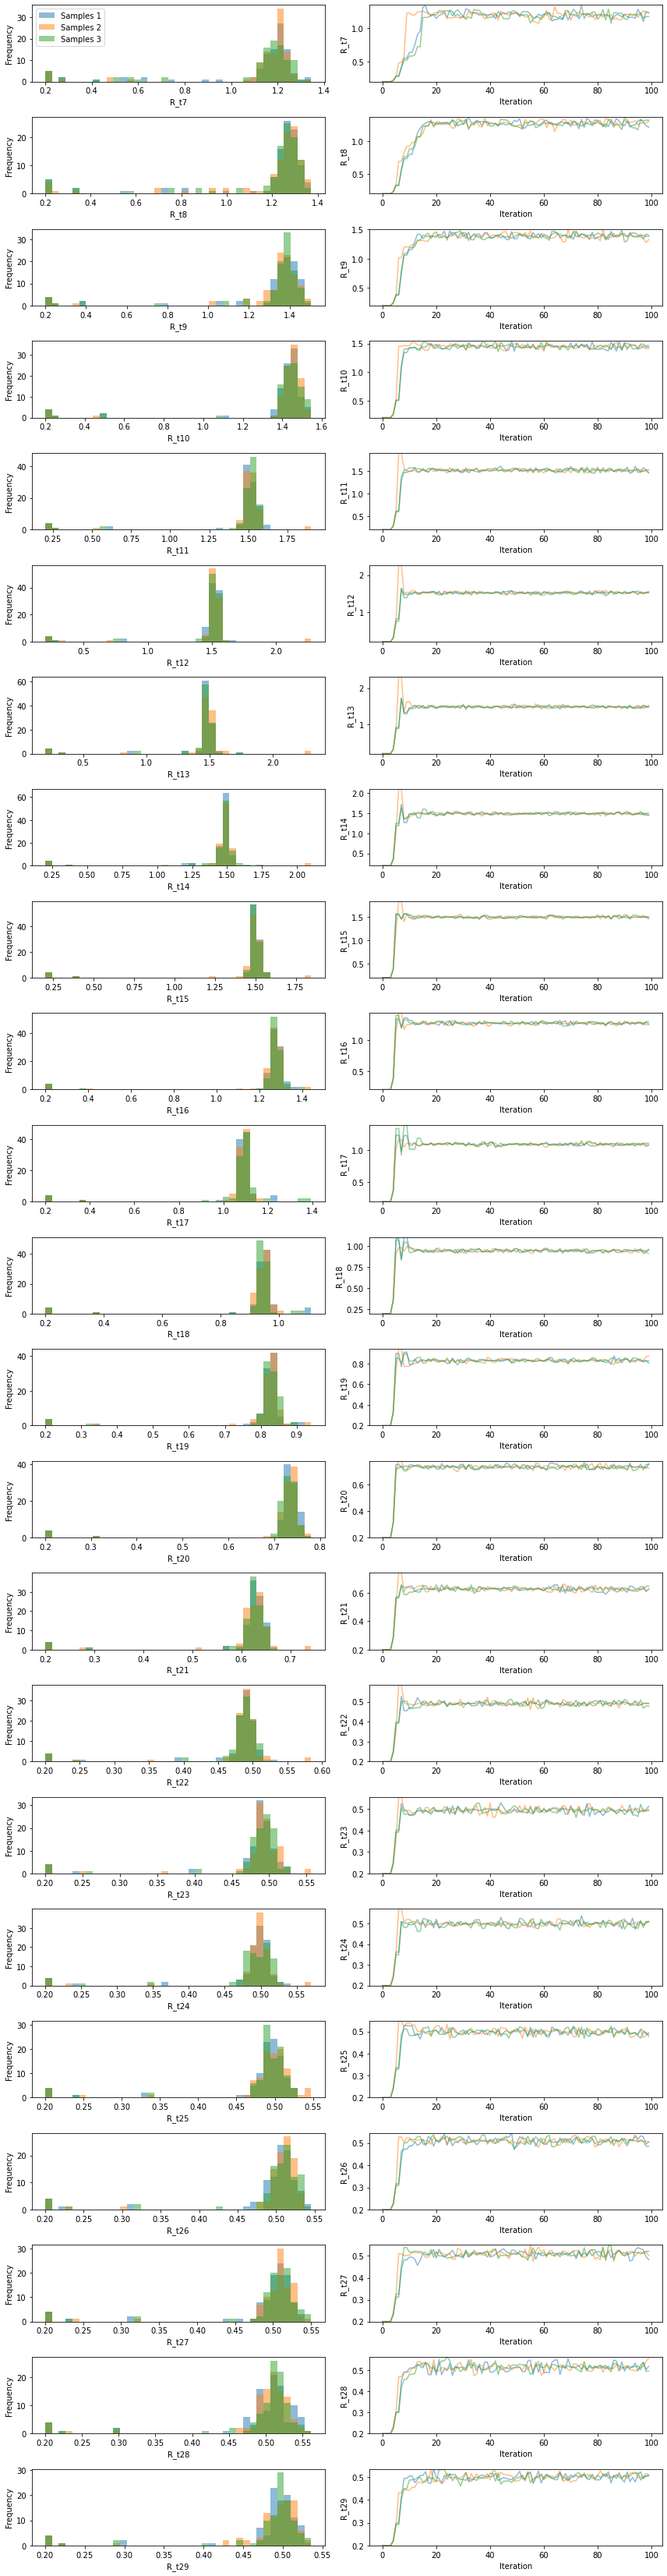

In [11]:
samples = inference_new.run_inference(num_iter=100)

import pints.plot
from matplotlib import pyplot as plt

# Plot histograms of the parameters inferred for South West
param_names = []
for _ in range(inference_new.lprior.n_parameters()):
            param_names.append('R_t{}'.format(_ + R_t_start))

pints.plot.trace(samples, parameter_names=param_names)
plt.show()

# Eliminate burn-in iterations (1/2 of the chain lengths)
samples = samples[:, 50:, :]

# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = samples.shape

extended_samples = np.concatenate((samples[0], samples[1], samples[2]), axis=0)

thinning = max(1, int(n_sample * n_chains / 50))

new_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[::thinning, :], axis=0),
    'Lower bound CI': np.quantile(extended_samples[::thinning, :], 0.025, axis=0),
    'Upper bound CI': np.quantile(extended_samples[::thinning, :], 0.975, axis=0),
    'Central Probability': (L1+L2) * [0.95]
})

## Inference plot using class method results

In [12]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(new_intervals)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.



In [13]:
dLl = []
old_r_profile = [1]*(tau) + ground_truth['R_t'].to_list()

total_time = inference_new.ll.cases_times.max() - inference_new.ll.cases_times.min() + 1
time_init_inf_r = inference_new.ll._tau + 1

for _, time in enumerate(range(time_init_inf_r+1, total_time+1)):
    new_r_profile = old_r_profile.copy()
    new_r_profile[_] = old_r_profile[_] + 10**(-5)
    dLl.append((inference_new.ll(new_r_profile)-inference_new.ll(old_r_profile))/10**(-5))

print(dLl)
print(inference_new.ll._compute_derivative_log_likelihood(old_r_profile))

[107.38918499555437, 194.63410426396874, 341.8458945816383, 472.83081221394235, 653.8729183375835, 795.4127562697976, -13.330252841114996, -10.479750926606357, 3.1202100217342372, -443.2284767972305, -939.2713749548419, -1425.1418848289175, -1830.4508441360665, -2124.6836986392736, -2387.6764462329447, -72.25489825941622, -37.89686015807092, -7.4560317443683735, -12.639371561817823, 47.104837722145014, 47.696710680611424, 52.685657283291214, 4.840685869567096]
[107.39235467569438, 194.63855877538174, 341.85189427365935, 472.83834304552516, 653.8824435634892, 795.4243026492472, -13.324201736688792, -10.47249122203175, 3.1287882121504254, -443.2199749370821, -939.2629051429032, -1425.1337454513643, -1830.4432896902567, -2124.6768690654903, -2387.6706920740144, -72.21619692848475, -37.860642673782934, -7.423651840717525, -12.611012955040906, 47.1305941129782, 47.71988854185952, 52.706815743798586, 4.859684981192515]


In [14]:
theta_hat = inference_new.run_optimisation()[0]
S_vector = np.multiply(np.reciprocal(np.array(shape)-1), np.square(theta_hat))
S = np.diag(S_vector)

q_theta = scipy.stats.multivariate_normal(theta_hat, S)
q_theta1 = scipy.stats.norm(theta_hat, np.sqrt(S_vector))
interval2 = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': q_theta.mean,
    'Lower bound CI': q_theta1.interval(0.95)[0],
    'Upper bound CI': q_theta1.interval(0.95)[1],
    'Central Probability': (L1+L2) * [0.95]
})

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 13
Iter. Eval.  Best      Current   Time m:s
0     13      226091.3  226091.3   0:00.1
1     26      226091.3  225732.2   0:00.1
2     39      230380    230380     0:00.1
3     52      235049.7  235049.7   0:00.1
20    273     241461.8  240801.9   0:00.4
40    533     242641.2  242641.2   0:00.8
60    793     242981.2  242981.2   0:01.1
80    1053    243032.4  243032.2   0:01.5
100   1313    243037.8  243037.4   0:01.8
120   1573    243038.5  243038.5   0:02.2
140   1833    243038.7  243038.7   0:02.5
160   2093    243038.7  243038.7   0:02.8
180   2353    243038.7  243038.7   0:03.2
198   2574    243038.7  243038.7   0:03.5
Halting: No significant change for 100 iterations.
[1.19404242 1.2718446  1.39107024 1.45167238 1.51737246 1.52087887
 1.48541399 1.48974924 1.4992146  1.27614176 1.09372982 0.94624338
 0.82906679 0.73582317 0.62875938 0.49046724 0.49441092 

In [15]:
fig = ReproductionNumberPlot()

fig.add_ground_truth_rt(ground_truth)
fig.add_interval_rt(interval2)

fig.update_labels(time_label='Time (Day)', r_label='R_t')

fig.show_figure()

/Users/ioaros/Desktop/Software Project/branchpro/branchpro/apps/_reproduction_number_plot.py:27: UserWarning:

Labels do not match. They will be updated.

